## Name : Ravikumar Uchadadiya (24070149027)

In [2]:
!pip install torch torchvision numpy matplotlib scipy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

batch_size = 128

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:18<00:00, 9.02MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*32*32),
            nn.Tanh()  # Output in range [-1,1]
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 3, 32, 32)  # Reshape to (3,32,32)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3*32*32, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Probability of real (for BCE Loss)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten image
        return self.model(img_flat)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss functions (for BCE, LS-GAN, and WGAN)
criterion_bce = nn.BCELoss()
criterion_ls = nn.MSELoss()

In [8]:
def train_gan_bce(epochs=50):
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            g_loss = criterion_bce(discriminator(fake_imgs), real_labels)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion_bce(discriminator(real_imgs), real_labels)
            fake_loss = criterion_bce(discriminator(fake_imgs.detach()), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        print(f"Epoch [{epoch+1}/{epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

In [9]:
def train_gan_ls(epochs=50):
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            g_loss = criterion_ls(discriminator(fake_imgs), real_labels)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion_ls(discriminator(real_imgs), real_labels)
            fake_loss = criterion_ls(discriminator(fake_imgs.detach()), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        print(f"Epoch [{epoch+1}/{epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

In [10]:
def train_gan_wgan(epochs=50):
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            g_loss = -torch.mean(discriminator(fake_imgs))  # WGAN Loss
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = -torch.mean(discriminator(real_imgs))
            fake_loss = torch.mean(discriminator(fake_imgs.detach()))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Clip weights for WGAN stability
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

        print(f"Epoch [{epoch+1}/{epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


In [11]:
train_gan_bce(50)  # Train BCE Loss GAN
train_gan_ls(50)   # Train LS-GAN
train_gan_wgan(50) # Train WGAN

Epoch [1/50] - D Loss: 0.0560, G Loss: 4.2712
Epoch [2/50] - D Loss: 0.5340, G Loss: 0.7251
Epoch [3/50] - D Loss: 0.0987, G Loss: 2.3123
Epoch [4/50] - D Loss: 0.0573, G Loss: 2.4961
Epoch [5/50] - D Loss: 0.1749, G Loss: 2.4370
Epoch [6/50] - D Loss: 0.1302, G Loss: 1.9050
Epoch [7/50] - D Loss: 0.0602, G Loss: 2.5091
Epoch [8/50] - D Loss: 0.2196, G Loss: 1.7521
Epoch [9/50] - D Loss: 0.0855, G Loss: 3.7102
Epoch [10/50] - D Loss: 0.1354, G Loss: 2.1011
Epoch [11/50] - D Loss: 0.2100, G Loss: 2.6186
Epoch [12/50] - D Loss: 0.1182, G Loss: 2.9259
Epoch [13/50] - D Loss: 0.1808, G Loss: 2.2766
Epoch [14/50] - D Loss: 0.1640, G Loss: 2.9710
Epoch [15/50] - D Loss: 0.1367, G Loss: 2.6193
Epoch [16/50] - D Loss: 0.3417, G Loss: 3.7115
Epoch [17/50] - D Loss: 0.2583, G Loss: 2.6775
Epoch [18/50] - D Loss: 0.3003, G Loss: 2.2311
Epoch [19/50] - D Loss: 0.2314, G Loss: 2.8055
Epoch [20/50] - D Loss: 0.2260, G Loss: 2.7706
Epoch [21/50] - D Loss: 0.2426, G Loss: 2.1411
Epoch [22/50] - D Loss

In [13]:
# Save BCE-GAN models
torch.save(generator.state_dict(), "/content/drive/MyDrive/generator_bce.pth")
torch.save(discriminator.state_dict(), "/content/drive/MyDrive/discriminator_bce.pth")

# Train LS-GAN
train_gan_ls(50)

# Save LS-GAN models
torch.save(generator.state_dict(), "/content/drive/MyDrive/generator_ls.pth")
torch.save(discriminator.state_dict(), "/content/drive/MyDrive/discriminator_ls.pth")

# Train WGAN
train_gan_wgan(50)

# Save WGAN models
torch.save(generator.state_dict(), "/content/drive/MyDrive/generator_wgan.pth")
torch.save(discriminator.state_dict(), "/content/drive/MyDrive/discriminator_wgan.pth")


AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'

In [12]:
from google.colab import drive
drive.mount('/content/drive')

# Save the models to your Google Drive
torch.save(generator.state_dict(), "/content/drive/MyDrive/generator.pth")
torch.save(discriminator.state_dict(), "/content/drive/MyDrive/discriminator.pth")

Mounted at /content/drive


In [17]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved Generator model
generator = Generator(latent_dim).to(device)
generator.load_state_dict(torch.load("/content/drive/MyDrive/generator.pth", map_location=device))
generator.eval()  # Set to evaluation mode

<ipython-input-17-ee2a7347fda0>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/content/drive/MyDrive/generator.pth", map_location=de

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=3072, bias=True)
    (7): Tanh()
  )
)

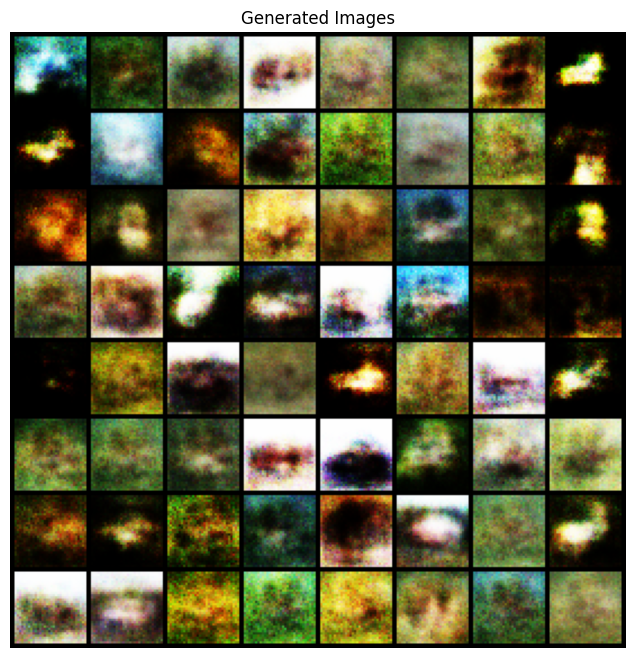

In [20]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def generate_images(generator, num_images=64):
    noise = torch.randn(num_images, latent_dim, device=device)  # Remove (1,1) dimensions
    fake_images = generator(noise).detach().cpu()

    # Ensure the output shape matches (batch_size, 3, H, W)
    if fake_images.dim() == 2:
        fake_images = fake_images.view(num_images, 3, 64, 64)  # Reshape if necessary

    # Plot the generated images
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(vutils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
    plt.show()

generate_images(generator, num_images=64)

In [24]:
!pip install torchmetrics[image] torch-fidelity

In [5]:
import torch

checkpoint = torch.load("/content/drive/MyDrive/generator.pth", map_location="cpu")
print(checkpoint.keys())


odict_keys(['model.0.weight', 'model.0.bias', 'model.2.weight', 'model.2.bias', 'model.4.weight', 'model.4.bias', 'model.6.weight', 'model.6.bias'])


<ipython-input-5-4b258c792c22>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/generator.pth", map_location="cpu")


In [11]:
import torch
from torchvision import transforms
from PIL import Image
import os

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to generator and discriminator models
generator_path = "/content/drive/MyDrive/generator.pth"
discriminator_path = "/content/drive/MyDrive/discriminator.pth"

# Load models
generator = torch.load(generator_path, map_location=device)
discriminator = torch.load(discriminator_path, map_location=device)
generator.eval()
discriminator.eval()

# Transformation for input images
transform = transforms.Compose([
    transforms.Resize((256, 144)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


<ipython-input-11-bee7eed27b24>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator = torch.load(generator_path, map_location=device)
<ipython-input-11-bee7eed27b24>

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [14]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader, Dataset
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Generator (same architecture as during training)
class Generator(torch.nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 3*32*32),
            torch.nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 3, 32, 32)

# Load Generator
latent_dim = 100
generator = Generator(latent_dim).to(device)
generator.load_state_dict(torch.load("/content/drive/MyDrive/generator.pth", map_location=device))
generator.eval()

print("Generator loaded successfully!")


Generator loaded successfully!


<ipython-input-14-34f4cf2337cb>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/content/drive/MyDrive/generator.pth", map_location=d

In [15]:
import torch.nn.functional as F
from torchvision.models import inception_v3

def compute_inception_score(generator, latent_dim, num_samples=5000, batch_size=128):
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.fc = torch.nn.Identity()  # Remove final classification layer
    inception_model.eval()

    preds = []

    with torch.no_grad():
        for _ in range(num_samples // batch_size):
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            fake_imgs = F.interpolate(fake_imgs, size=(299, 299), mode='bilinear')  # Resize for Inception
            fake_imgs = (fake_imgs + 1) / 2  # Scale to [0,1]

            pred = F.softmax(inception_model(fake_imgs), dim=1)
            preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    kl_div = preds * (np.log(preds) - np.log(np.expand_dims(np.mean(preds, axis=0), axis=0)))
    inception_score = np.exp(np.mean(np.sum(kl_div, axis=1)))

    return inception_score

# Compute IS
inception_score = compute_inception_score(generator, latent_dim)
print(f"Inception Score (IS): {inception_score:.4f}")


Inception Score (IS): 1.0510


<ipython-input-18-15616331aa61>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/content/drive/MyDrive/generator.pth"))
<ipython-inpu

✅ Models loaded successfully!
Files already downloaded and verified
✅ Real image DataLoader is ready!
🔥 Fréchet Inception Distance (FID): 275.7184


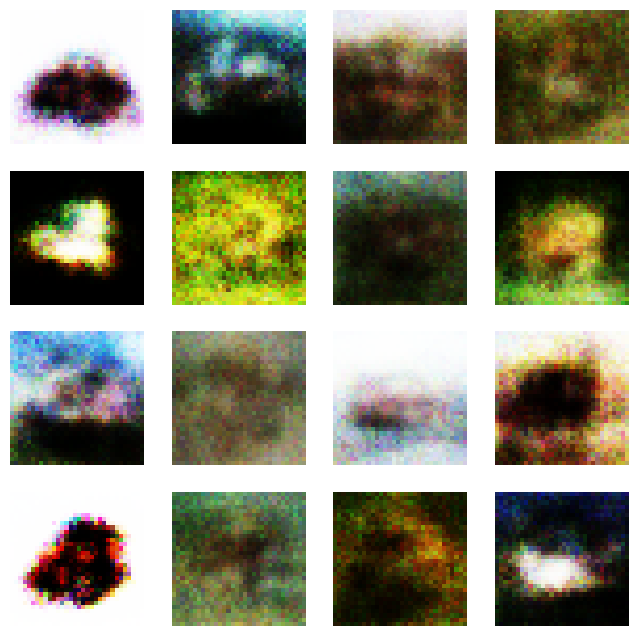

In [18]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.linalg import sqrtm
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import inception_v3
import matplotlib.pyplot as plt
import torch.nn as nn

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Generator class (Ensure it matches the one used during training)
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 32*32*3),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 32, 32)  # CIFAR-10 images (3x32x32)
        return img

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3*32*32, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Load trained models
latent_dim = 100  # Ensure this matches training config

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

generator.load_state_dict(torch.load("/content/drive/MyDrive/generator.pth"))
discriminator.load_state_dict(torch.load("/content/drive/MyDrive/discriminator.pth"))

generator.eval()
discriminator.eval()

print("✅ Models loaded successfully!")

# Keep the same transformation as before
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

batch_size = 128

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("✅ Real image DataLoader is ready!")

# Compute FID Score
def compute_fid(generator, dataloader, latent_dim, num_samples=5000):
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.fc = torch.nn.Identity()
    inception_model.eval()

    real_features, fake_features = [], []

    with torch.no_grad():
        # Extract features for real images
        for real_imgs, _ in dataloader:
            real_imgs = real_imgs.to(device)
            real_imgs = F.interpolate(real_imgs, size=(299, 299), mode='bilinear')
            real_imgs = (real_imgs + 1) / 2  # Convert from [-1,1] to [0,1]
            real_features.append(inception_model(real_imgs).cpu().numpy())

        # Extract features for fake images
        for _ in range(num_samples // batch_size):
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            fake_imgs = F.interpolate(fake_imgs, size=(299, 299), mode='bilinear')
            fake_imgs = (fake_imgs + 1) / 2
            fake_features.append(inception_model(fake_imgs).cpu().numpy())

    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)

    # Compute mean and covariance
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Compute FID
    diff = mu_real - mu_fake
    cov_sqrt, _ = sqrtm(sigma_real @ sigma_fake, disp=False)
    fid_score = np.real(np.sum(diff**2) + np.trace(sigma_real + sigma_fake - 2 * cov_sqrt))

    return fid_score

# Compute FID
fid_score = compute_fid(generator, dataloader, latent_dim)
print(f"🔥 Fréchet Inception Distance (FID): {fid_score:.4f}")

# Visual Inspection of Generated Images
def visualize_images(generator, latent_dim, num_images=16):
    generator.eval()
    z = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        generated_images = generator(z).cpu()

    generated_images = (generated_images + 1) / 2  # Convert from [-1,1] to [0,1]

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = generated_images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis("off")

    plt.show()

# Show generated images
visualize_images(generator, latent_dim, num_images=16)
